In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error


In [7]:
# Класс для хранения свойств
class Property:
   def __init__(self, name, values):
      self.name = name
      self.values = values
   name = ""
   values = []
   k = 0

# Инициализация
propertyList = []
K_VALUE = 0.65

def rmsle(y_true, y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def read_file():
   with open("data_description.txt", "r") as f:
      for line in f.readlines():
         isName = False
         isValues = False

         if line.startswith("\n") or line.startswith("\t"):
            continue
         elif line.startswith(' '):
            isValues = True
         else:
            isName = True

         if isName == True:
            for word in line.split(':'):
               propertyList.append(Property(word, []))
               break
            continue
         elif isValues == True:
            cnt = 0
            for i in line:
               cnt += 1
               if i != ' ':
                  word = line[cnt - 1: line.find('\t')]
                  break
            propertyList[len(propertyList) - 1].values.append(word)

def df_string_to_number(df):
   dfCopy = df.copy(deep=True)

   for column in dfCopy.columns.values.tolist():
      for property in propertyList:
         if column == property.name:
            for i in range(len(property.values)):
               dfCopy[column] = dfCopy[column].replace([property.values[i]], int(len(property.values) - i))
            break

      # Зануляем пустые значения
      dfCopy[column] = dfCopy[column].replace(np.nan, 0)

      # Зануляем строки, которых нет в параметрах
      for value in dfCopy[column]:
         if type(value) is str:
            dfCopy[column] = dfCopy[column].replace([value], 0)

   return dfCopy


MSSubClass -0.08428413512659517
MSZoning 0.27622832900723815
LotFrontage 0.20962394479948393
LotArea 0.2638433538714056
Street -0.04103553550004952
Alley -0.13532237937420874
LotShape -0.2677593139178231
LandContour -0.0730415748938042
Utilities 0.014314296147248806
LotConfig -0.09231596731484681
LandSlope -0.05115224817946656
Neighborhood -0.17888347720191372
Condition1 -0.08383810316349827
Condition2 -0.05748974496315127
BldgType 0.11261070204133268
HouseStyle -0.06354695551843959
OverallQual 0.7909816005838052
OverallCond -0.077855894048678
YearBuilt 0.5228973328794968
YearRemodAdd 0.5071009671113862
RoofStyle -0.22240529240713855
RoofMatl -0.13238311192778818
Exterior1st -0.11961435719139464
Exterior2nd -0.111485145197939
MasVnrType 0.06394153894420491
MasVnrArea 0.47261449900457386
ExterQual 0.6826392416562593
ExterCond 0.018899118482413036
Foundation -0.3824789911901017
BsmtQual 0.5452185412719267
BsmtCond 0.20445177768945771
BsmtExposure 0.37918500225320007
BsmtFinType1 0.309267

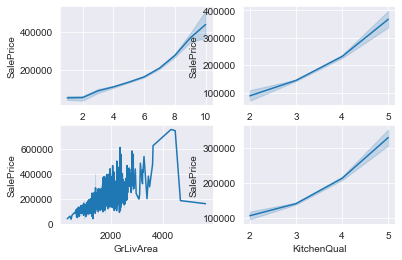

In [8]:
# Чтение файла
read_file()

# Считываем данные как dataframe
dfTrain = pd.read_csv('./train.csv')
dfTrainCopy = df_string_to_number(dfTrain)
dfTrainCopy.to_csv('result_1.csv', index=False)

# Получаем коэффициенты корреляции
chooseProperty = []
for property in propertyList:
        property.k = dfTrainCopy[property.name].corr(dfTrainCopy['SalePrice'])
        print(property.name, property.k)

        if property.k >= K_VALUE:
            chooseProperty.append(property.name)

    # Отрисовываем графики
cnt = 0
for property in propertyList:
    if property.k >= K_VALUE:
        cnt += 1
        sns.set_style("darkgrid")
        plt.subplot(int(len(chooseProperty) / 2), 2, cnt)
        sns.lineplot(data=dfTrainCopy, x=property.name, y="SalePrice")

print("\n\n ========================= \n")
print("[LOG] Count items in chooseProperty[]: " + str(cnt))

X = dfTrainCopy[chooseProperty]
Y = dfTrainCopy.SalePrice

In [9]:
# Разделение на train и validation
# Обучать будем на 75% данных, проверять на 25%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
# X_train = X_train
# y_train = y_train
# X_test = X_test
# y_test = y_test

# # Обучение модели и получение предсказания
lr = LinearRegression()
lr.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
prediction = lr.predict(X_test)

In [10]:
mae = mean_absolute_error(y_test, prediction)
print("[LOG] mae: " + str(mae))

# Средняя абсолютная ошибка
result = rmsle(y_test, prediction)
print("[LOG] rmsle: " + str(result))


# Модель сделана, теперь нужно сделать предсказание на тестовых данных
dfTest = pd.read_csv('./test.csv')

dfTestCopy = df_string_to_number(dfTest)
dfTestCopy = dfTestCopy[chooseProperty]

dfTestCopy.to_csv('result_2.csv', index=False)

pred = lr.predict(dfTestCopy)
dfTestCopy.drop(chooseProperty, axis=1, inplace=True)
dfTestCopy['Id'] = dfTest['Id']
dfTestCopy['SalePrice'] = pred

dfTestCopy.to_csv('result_3.csv', index=False)

print("[LOG] Done!")

[LOG] mae: 26343.125370846872
[LOG] rmsle: 0.2782512955574505
[LOG] Done!
